# RNN with GRUs

Implemented as in *Shape and Time Distortion Loss for Training Deep Time Series Forecasting Models (2019)* https://arxiv.org/abs/1909.09020

In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

import sys
sys.path.append('..')

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle

import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from datasets import Traffic, ECG5000, split_dataset
from models.rnn_dilate import EncoderRNN, DecoderRNN, NetGRU, train_model, get_forecasts

from metrics import calc_tdi_tdm, squared_error, absolute_error
from utilities import plot_forecasts, Evaluation

In [6]:
# CONTROLS
LOAD = False # whether to load or train model

# Dataset: ECG5000

DILATE GRU: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:06<00:00,  6.33s/epoch, train_loss=0.0498]


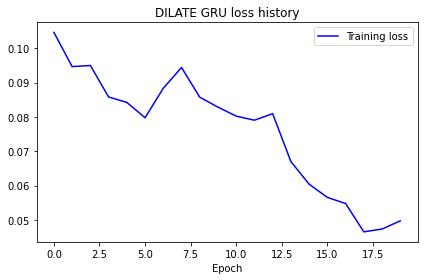

In [7]:
# Parameters
window = 84
horizon = 56
batch_size = 10
epochs = 20
lr = 0.01
 
# Load data
ecg_train = ECG5000("../data/ECG5000/ECG5000_TRAIN.tsv", window, horizon)
ecg_test = ECG5000("../data/ECG5000/ECG5000_TEST.tsv", window, horizon)
ecg_train_loader = torch.utils.data.DataLoader(ecg_train, batch_size=batch_size, shuffle=True, drop_last=True)
ecg_test_loader = torch.utils.data.DataLoader(ecg_train, batch_size=batch_size, shuffle=False, drop_last=True)

# Build model
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, fc_units=16, output_size=1).to(device)
gru_net = NetGRU(encoder, decoder, horizon, device).to(device)
optimizer = torch.optim.Adam(gru_net.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()
    
# Train and save model OR load model from pickle
if not LOAD:    
    train_model(gru_net, optimizer, loss_fn, ecg_train_loader, epochs=epochs)
    
    with open('./saved_models/grudilate_ecg.pickle', 'wb') as handle:
        pickle.dump(gru_net, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./saved_models/grudilate_ecg.pickle', 'rb') as handle:
        gru_net = pickle.load(handle)

# Get forecasts on test
x_test, y_test, yhat_test = get_forecasts(gru_net, ecg_test_loader)

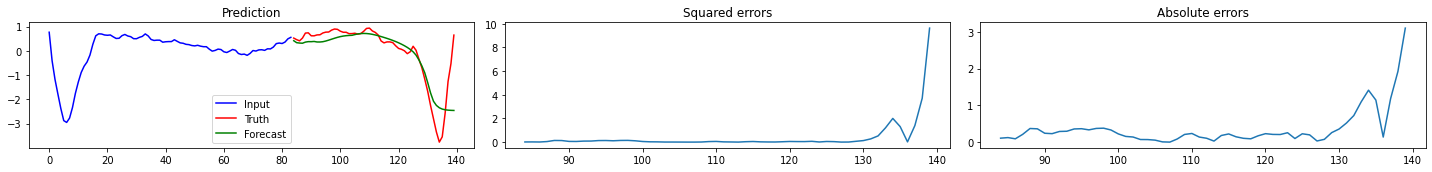

TDI: 0.17, TDM: 0.92 


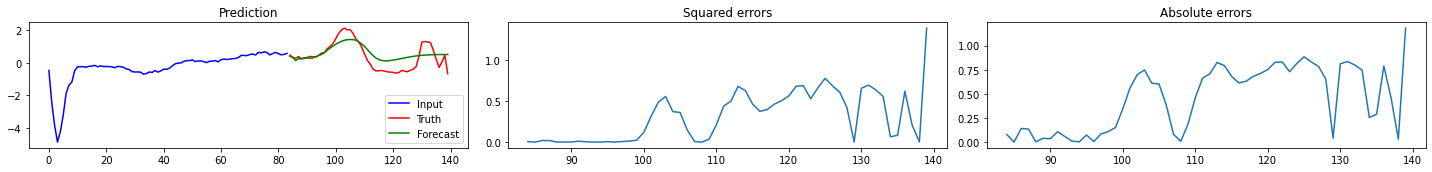

TDI: 0.09, TDM: 0.04 


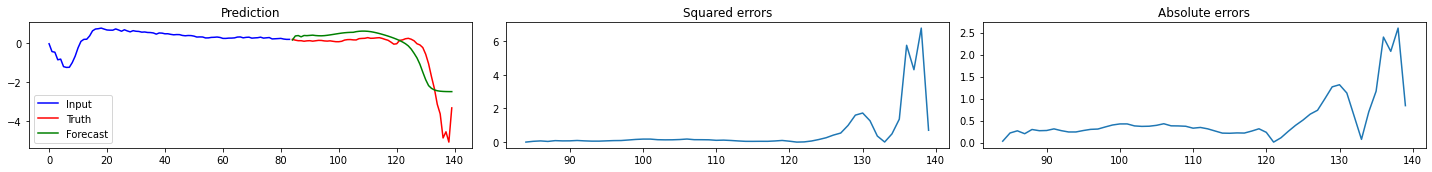

TDI: 0.27, TDM: -0.73 


In [8]:
# Plots
plot_forecasts(x_test, y_test, yhat_test, n=3, shuffle=True)

Evaluation of method 'GRU' on dataset 'ECG5000', a total of 500 56-step forecasts.



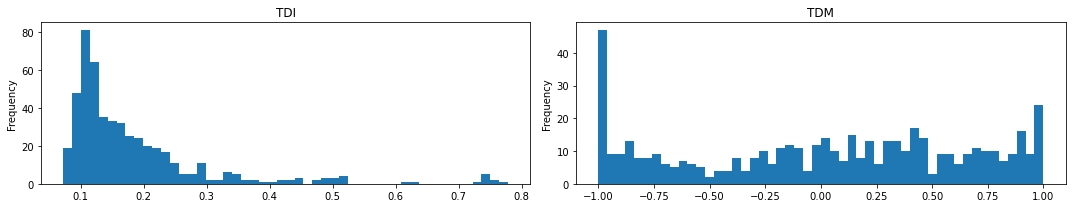

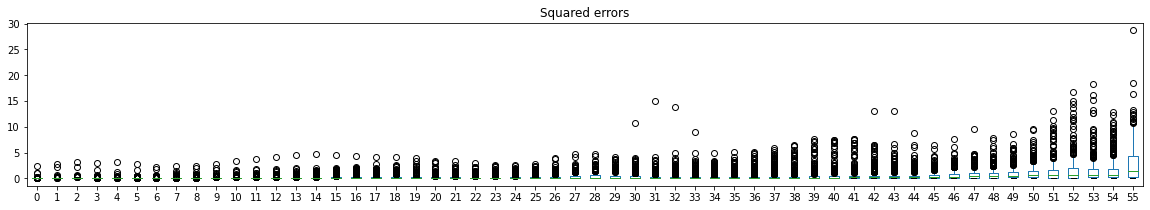

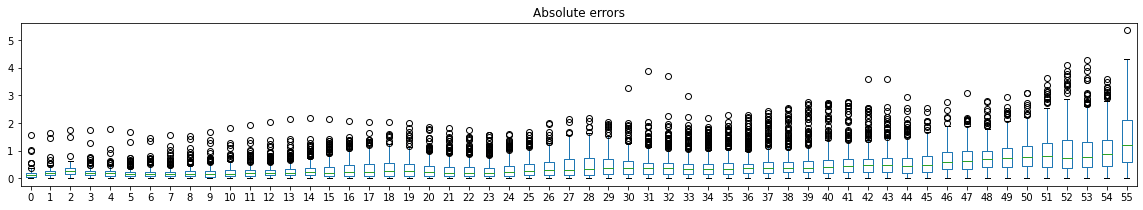

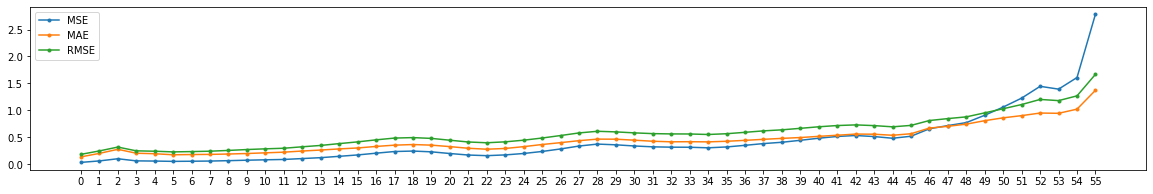

In [9]:
# Compute evaluation
res_ecg = Evaluation(y_test, yhat_test, "ECG5000", "GRU")
print(res_ecg)
res_ecg.plot()

# Dataset: Traffic

DILATE GRU: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:46<00:00, 29.31s/epoch, train_loss=3.07e-5]


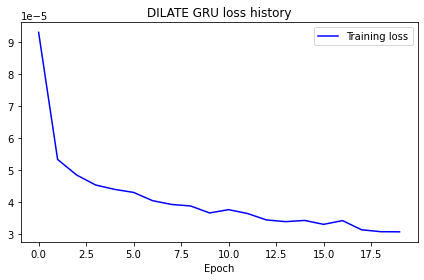

In [11]:
# Parameters
window = 24
horizon = 24
batch_size = 32
epochs = 20
lr = 0.01
 
# Load data
ds = Traffic("../data/mvdata/traffic.txt", 24, 24, usecol=0)
traffic_train, traffic_test = split_dataset(ds, 0.2)
traffic_train_loader = torch.utils.data.DataLoader(traffic_train, batch_size=batch_size, shuffle=True, drop_last=True)
traffic_test_loader = torch.utils.data.DataLoader(traffic_test, batch_size=batch_size, shuffle=True, drop_last=True)

# Build model
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, fc_units=16, output_size=1).to(device)
gru_net = NetGRU(encoder, decoder, horizon, device).to(device)
optimizer = torch.optim.Adam(gru_net.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

# Train and save model OR load model from pickle
if not LOAD:    
    train_model(gru_net, optimizer, loss_fn, traffic_train_loader, epochs=epochs)
    
    with open('./saved_models/grudilate_traffic.pickle', 'wb') as handle:
        pickle.dump(gru_net, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./saved_models/grudilate_traffic.pickle', 'rb') as handle:
        gru_net = pickle.load(handle)

# Get forecasts on test
x_test, y_test, yhat_test = get_forecasts(gru_net, traffic_test_loader)

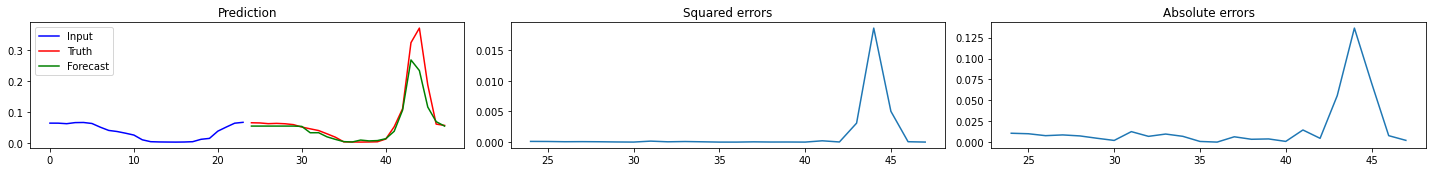

TDI: 0.03, TDM: -1.00 


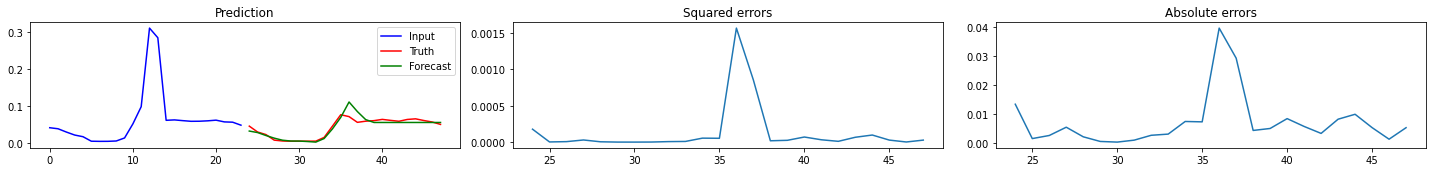

TDI: 0.13, TDM: -0.66 


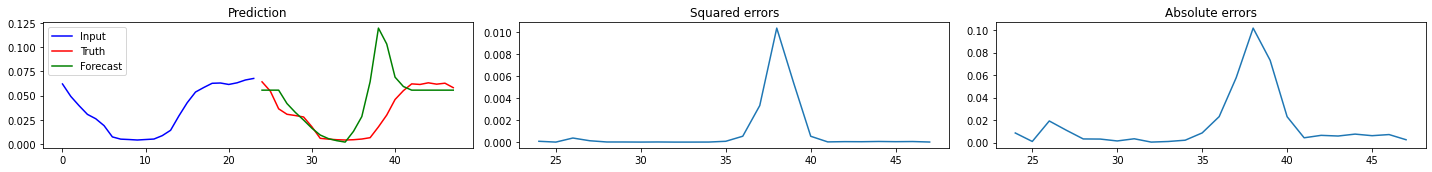

TDI: 0.18, TDM: -0.91 


In [12]:
# Plots
plot_forecasts(x_test, y_test, yhat_test, n=3, shuffle=True)

..\metrics.py:76: RuntimeWarning: invalid value encountered in double_scalars
  tdi_late = abs(np.trapz(j_l[indices], j_l[indices] - i_l[indices]) / np.trapz(j_l, abs(j_l - i_l)))


Evaluation of method 'GRU' on dataset 'Traffic', a total of 3488 24-step forecasts.



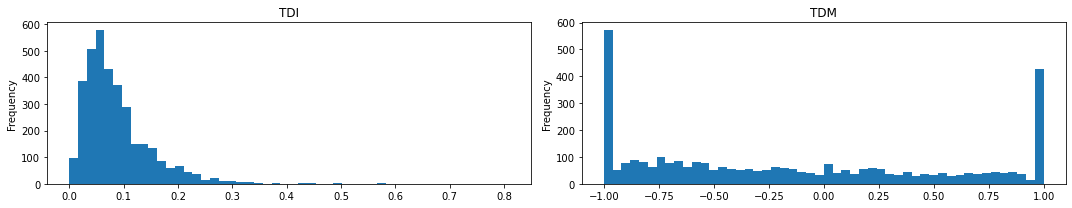

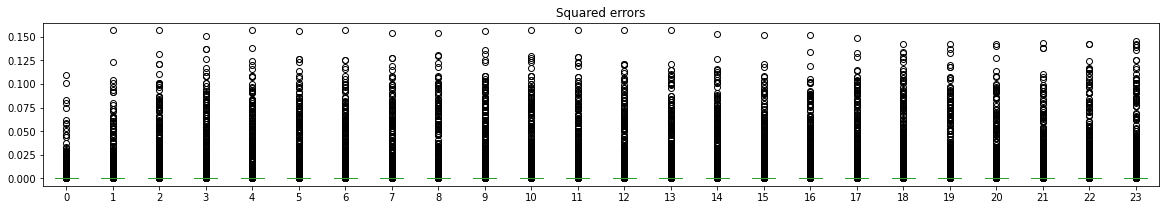

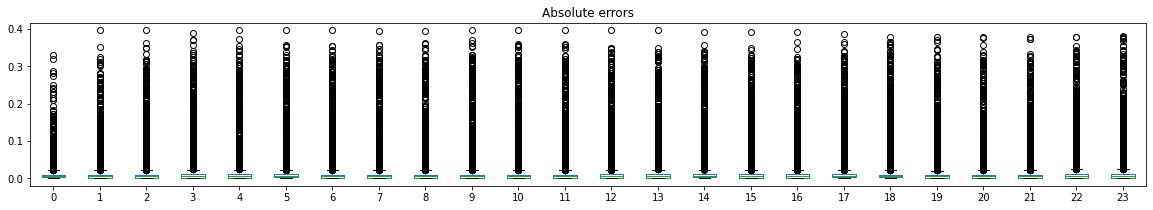

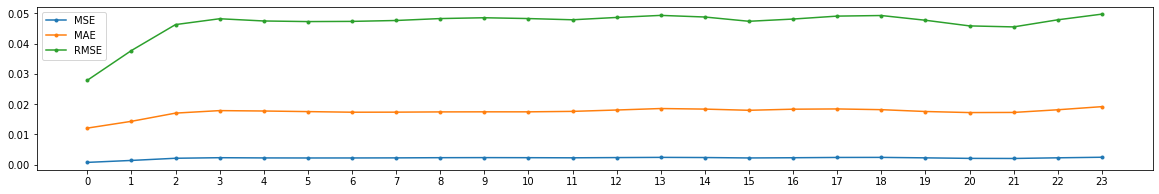

In [13]:
# Compute evaluation
res_traffic = Evaluation(y_test, yhat_test, "Traffic", "GRU")
print(res_traffic)
res_traffic.plot()